In [4]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import re
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
from shutil import unpack_archive
unpack_archive('mm.zip', './mmsample', "zip")

In [6]:
from skimage.io import imread
import os
from glob import glob
import h5py
%matplotlib inline 

In [7]:
base_h5 = os.path.join('.', 'mmsample','all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(5)

/tmp/ipykernel_58/1845099523.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  {k: v.value if len(v.shape)==1 else [sub_v for sub_v in v]


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan
124,G,ARCH,33.0,mdb124,M,366.0,620.0,mdb124.pgm,tiffs/mdb124.tif
287,G,NORM,NaN,mdb280,nan,NaN,NaN,mdb280.pgm,tiffs/mdb280.tif
64,D,NORM,NaN,mdb064,nan,NaN,NaN,mdb064.pgm,tiffs/mdb064.tif
78,F,NORM,NaN,mdb078,nan,NaN,NaN,mdb078.pgm,tiffs/mdb078.tif
1,G,CIRC,69.0,mdb002,B,522.0,280.0,mdb002.pgm,tiffs/mdb002.tif


In [8]:
mammo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BG        330 non-null    object 
 1   CLASS     330 non-null    object 
 2   RADIUS    119 non-null    float64
 3   REFNUM    330 non-null    object 
 4   SEVERITY  330 non-null    object 
 5   X         119 non-null    float64
 6   Y         119 non-null    float64
 7   path      330 non-null    object 
 8   scan      330 non-null    object 
dtypes: float64(3), object(6)
memory usage: 23.3+ KB


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, MobileNet, VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [29]:
from sklearn.preprocessing import LabelEncoder
class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])

In [30]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID
54,D,NORM,NaN,mdb054,nan,NaN,NaN,mdb054.pgm,tiffs/mdb054.tif,5


In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

Image dimensions: (1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

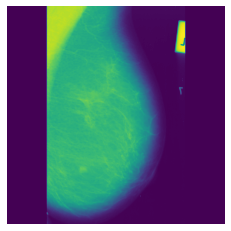

In [32]:
import matplotlib.pyplot as plt
example = './mmsample/all-mias/mdb256.pgm'
image = mpimg.imread(example)
print('Image dimensions:', image.shape)
plt.imshow(image)
plt.axis("off")


In [33]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    df_gen = img_data_gen.flow_from_dataframe(in_df, x_col=path_col,
                                              y_col=y_col,
                                     class_mode = 'raw',
                                    **dflow_args)
    return df_gen

In [34]:
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

train 247 validation 83


,BG,CLASS,RADIUS,REFNUM,SEVERITY,X,Y,path,scan,CLASS_ID
164,D,NORM,NaN,mdb162,nan,NaN,NaN,mdb162.pgm,tiffs/mdb162.tif,5


New Data Size: 1300 Old Size: 247


array([[<AxesSubplot:title={'center':'CLASS_ID'}>,
        <AxesSubplot:title={'center':'RADIUS'}>]], dtype=object)

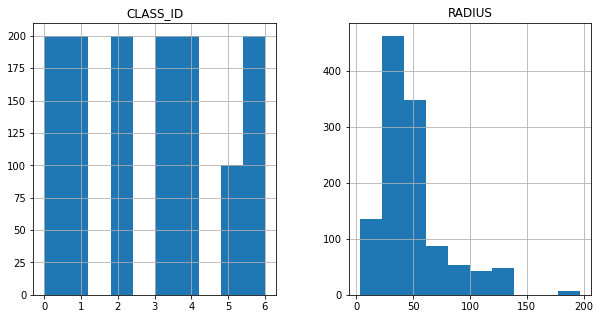

In [35]:
train_df = raw_train_df.groupby(['CLASS_ID', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.15, 
                              width_shift_range = 0.15, 
                              rotation_range = 5, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range=0.2,
                             preprocessing_function = preprocess_input)

In [46]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_ID', 
                            target_size = (224, 224),
                             color_mode = 'rgb',
                            batch_size = 112)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_ID', 
                            target_size = (224, 224),
                             color_mode = 'rgb',
                            batch_size = 112) 
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'scan',
                            y_col = 'CLASS_ID', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 112))

Found 1300 validated image filenames.
Found 83 validated image filenames.
Found 83 validated image filenames.


In [47]:
from tensorflow.keras.applications import VGG19

In [48]:
model1 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')

In [49]:
model1.trainable = False

In [50]:
import tensorflow as tf

In [51]:
checkpont_mod1 = '/home/jovyan/Thesis/sample5/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpont_mod1,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      save_best_only=True)

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)

In [54]:
inputs = model1.input
x = Dense(128, activation='relu')(model1.output)
x = Dropout(0.01)(x)
outputs = Dense(1, activation='sigmoid')(x)
model1_1 = Model(inputs=inputs, outputs=outputs)

In [55]:
model1_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [56]:
history = model1_1.fit(train_gen, epochs=5, validation_data=valid_gen, callbacks=[checkpoint_callback, early_stopping])

2023-04-11 19:15:51.819905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-11 19:15:51.820262: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999990000 Hz


Epoch 1/5
12/12 [==============================] - 331s 28s/step - loss: 0.0000e+00 - precision_1: 0.8500 - recall_1: 0.9529 - val_loss: 0.0000e+00 - val_precision_1: 0.9398 - val_recall_1: 1.0000
Epoch 2/5
12/12 [==============================] - 329s 27s/step - loss: 0.0000e+00 - precision_1: 0.8439 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_precision_1: 0.9398 - val_recall_1: 1.0000
Epoch 3/5
12/12 [==============================] - 329s 28s/step - loss: 0.0000e+00 - precision_1: 0.8502 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_precision_1: 0.9398 - val_recall_1: 1.0000
Epoch 4/5
12/12 [==============================] - 329s 28s/step - loss: 0.0000e+00 - precision_1: 0.8382 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_precision_1: 0.9398 - val_recall_1: 1.0000
Epoch 5/5
12/12 [==============================] - 330s 28s/step - loss: 0.0000e+00 - precision_1: 0.8440 - recall_1: 1.0000 - val_loss: 0.0000e+00 - val_precision_1: 0.9398 - val_recall_1: 1.0000


In [57]:
pred_Y = model1_1.predict(test_X, batch_size = 32, verbose = True)
pred_Y_cat = np.argmax(pred_Y,-1)
test_Y_cat = test_Y

3/3 [==============================] - 20s 6s/step


              precision    recall  f1-score   support

        ARCH       0.06      1.00      0.11         5
        ASYM       0.00      0.00      0.00         3
        CALC       0.00      0.00      0.00         8
        CIRC       0.00      0.00      0.00         6
        MISC       0.00      0.00      0.00         4
        NORM       0.00      0.00      0.00        52
        SPIC       0.00      0.00      0.00         5

    accuracy                           0.06        83
   macro avg       0.01      0.14      0.02        83
weighted avg       0.00      0.06      0.01        83



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


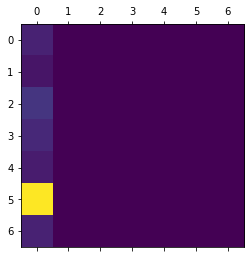

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(test_Y_cat, pred_Y_cat))
print(classification_report(test_Y_cat, pred_Y_cat, target_names = class_enc.classes_))